# Chapter 2: Loading and visualizing data

In [1]:
import configparser
from getpass import getuser
config = configparser.ConfigParser()
config.read(f"../config/{getuser()}.ini")
if len(config.sections()) == 0:
    config.read("../config/default.ini")
DATA_PATH = config["Data"]["path"]

## Construct a DataFrame from the .json files

In [2]:
import os
import json
import pandas as pd

THLD_NEUTRAL = 0.2

data = []

for file in os.listdir(DATA_PATH):
    if file.endswith(".json"):
        with open(os.path.join(DATA_PATH, file), "r", encoding="utf-8") as f:
            data.append(json.load(f))

df = pd.DataFrame(data)
df["Time_Published"] = pd.to_datetime(df["Time_Published"])

df["Sentiment"] = df.apply(lambda x: 1 if x["Polarity"] > THLD_NEUTRAL else 0 if abs(x["Polarity"]) <= THLD_NEUTRAL else -1, axis=1)
df = df[(df["Positive"] + df["Negative"] == 0) | (df["Positive"] + df["Negative"] > 4)] # Only keep entries with no votes (neutral) or more than 4 votes

from sklearn.utils import shuffle
df = shuffle(df, random_state=10)

print(df.shape)

(7256, 11)


## Data Cleaning

In [3]:
import re

FEATURE_NAME = "Body_Text"

df[FEATURE_NAME] = df.apply(lambda r: re.sub("<.*?>", " ", r[FEATURE_NAME]), axis=1)
df[FEATURE_NAME] = df.apply(lambda r: re.sub("\\u00a0", " ", r[FEATURE_NAME]), axis=1)
df[FEATURE_NAME] = df.apply(lambda r: re.sub("(?i)COVID-19", "coronavirus", r[FEATURE_NAME]), axis=1)
df[FEATURE_NAME] = df.apply(lambda r: re.sub("(?i)COVID19", "coronavirus", r[FEATURE_NAME]), axis=1)
df[FEATURE_NAME] = df.apply(lambda r: re.sub("(?i)COVID", "coronavirus", r[FEATURE_NAME]), axis=1)

df = df.drop_duplicates(subset="Body_Text")
df = df[df["Body_Text"] != ""]
print(df.shape)

(5920, 11)


First few entries in the DataFrame

In [4]:
df.head()

,Title,URL,Time_Published,Body_Text,Company,Symbol,Positive,Negative,Polarity,News_Id,Sentiment
4883,Charles Li: HK Stocks Resilient; Recent Turnov...,http://www.aastocks.com/en/stocks/news/aafn-co...,2021-01-14 15:10:00,HKEX ex-CEO Charles Li found it hard to predic...,HKEX,00388.HK,31,13,0.409091,NOW.1069199,1
5685,A-LIVING (03319.HK) Sees FY20 NP Up At Least 4...,http://www.aastocks.com/en/stocks/news/aafn-co...,2021-01-25 08:19:00,"A-LIVING has issued a positive profit alert, e...",A-LIVING,03319.HK,71,27,0.448980,NOW.1071381,1
4708,US WeChat Users File Lawsuit Against TENCENT f...,http://www.aastocks.com/en/stocks/news/aafn-co...,2021-01-13 08:50:00,U.S. NGO Citizen Power Initiatives for China a...,U.S. NGO Citizen Power Initiatives for China a...,00700.HK,46,44,0.022222,NOW.1068710,0
5228,Carrie Lam: Jobless Claim Hardly Feasible in H...,http://www.aastocks.com/en/stocks/news/aafn-co...,2021-01-19 10:24:00,In response to street proposals for unemployme...,,,4,16,-0.600000,NOW.1070189,-1
3574,ESPRIT HOLDINGS (00330.HK) Non-exec. Chair Ray...,http://www.aastocks.com/en/stocks/news/aafn-co...,2020-12-28 00:26:00,ESPRIT HOLDINGS announced the resignation of R...,ESPRIT HOLDINGS,00330.HK,19,15,0.117647,NOW.1065294,0


## Save the DataFrame for later chapters

In [5]:
df.to_pickle(os.path.join(DATA_PATH, "df.pkl"))
# df.to_csv("df.csv") # Also save as .csv for easy inspection

## Load the pickle back into a DataFrame

In [6]:
import os
import pandas as pd
df = pd.read_pickle(os.path.join(DATA_PATH, "df.pkl"))
print(df.shape)

(5920, 11)


## Visualizing the data

### Polarity-Time chart

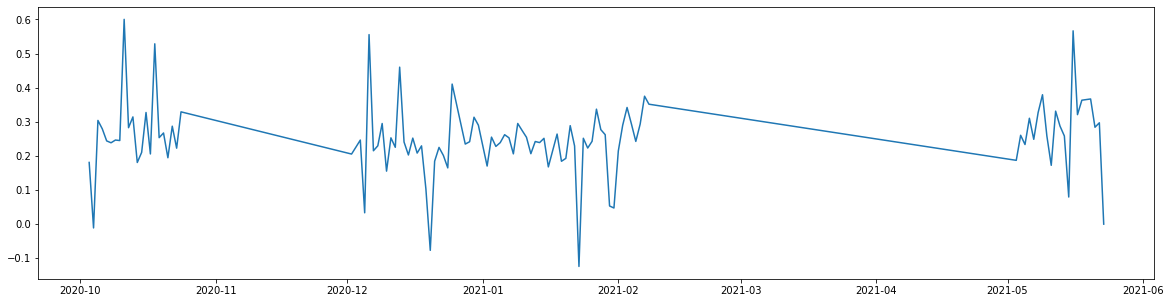

In [7]:
df_date_only = df.copy()
df_date_only["Time_Published"] = df["Time_Published"].dt.floor("d")
df_by_date = df_date_only.groupby(["Time_Published"], as_index=False).mean()
df_by_date.head()

import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(df_by_date["Time_Published"], df_by_date["Polarity"])

### Box plot for a date

In [8]:
import ipywidgets as widgets
wg = widgets.Dropdown(
    options=[(t.strftime("%Y-%m-%d"), t) for t in df_date_only["Time_Published"].drop_duplicates().to_list()],
    description='Date:'
)

out = widgets.Output()
display(out)
@out.capture()
def plot_box_plot(change):
    out.clear_output()
    df_date_only[df_date_only["Time_Published"] == wg.value].boxplot(column=["Polarity"])
    plt.show()

wg.on_displayed(plot_box_plot)
wg.observe(plot_box_plot, names=["value"])
display(wg)

Output()

Dropdown(description='Date:', options=(('2021-01-14', Timestamp('2021-01-14 00:00:00')), ('2021-01-25', Timest…

### Distribution of polarities

<BarContainer object of 3 artists>

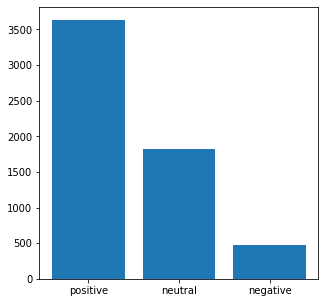

In [9]:
distr = {
    "positive": len(df[df["Sentiment"] == 1]),
    "neutral": len(df[df["Sentiment"] == 0]),
    "negative": len(df[df["Sentiment"] == -1]),
}

plt.figure(figsize=(5,5))
plt.bar(distr.keys(), distr.values())

So, the data is skewed towards the positive side (which is quite normal for crowdsourced sentiments like that on Stocktwits).

## Baseline using Zero Rule

In [10]:
print("Baseline accuracy:", max(distr.values()) / sum(distr.values()))

Baseline accuracy: 0.6138513513513514
